# <b>Binary Classification with a Tabular Stroke Prediction Dataset</b>

In [ ]:
# !pip install catboost
# !pip install tensorflow-addons

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import gc

# Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# ML model
import catboost as cb

# Tensorflow: NN model
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 1-1. Fixed Seed

In [ ]:
def seed_everything(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: stroke<br>
`test.csv`: 테스트 데이터 <br>

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


### 2-1. 데이터 설명

In [ ]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [ ]:
data_describe(train, 'Train')

====================== Train Data Describe ======================
Row: 15304, Column: 12
               Column    Dtype  Unique levels  Missing Count
0                  id    int64          15304              0
1              gender   object              3              0
2                 age  float64            106              0
3        hypertension    int64              2              0
4       heart_disease    int64              2              0
5        ever_married   object              2              0
6           work_type   object              5              0
7      Residence_type   object              2              0
8   avg_glucose_level  float64           3740              0
9                 bmi  float64            407              0
10     smoking_status   object              4              0
11             stroke    int64              2              0


In [ ]:
data_describe(test, 'Test')

====================== Test Data Describe ======================
Row: 10204, Column: 11
               Column    Dtype  Unique levels  Missing Count
0                  id    int64          10204              0
1              gender   object              3              0
2                 age  float64            106              0
3        hypertension    int64              2              0
4       heart_disease    int64              2              0
5        ever_married   object              2              0
6           work_type   object              5              0
7      Residence_type   object              2              0
8   avg_glucose_level  float64           3265              0
9                 bmi  float64            400              0
10     smoking_status   object              4              0


- 데이터에 결측값이 없음

In [ ]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

## 3. EDA

### 3-1. Features distribution

In [ ]:
# 수치형 변수
num_columns = test.select_dtypes(include=np.number).columns.tolist()
num_columns.remove('hypertension')
num_columns.remove('heart_disease')
print('수치형 변수:\n', num_columns)

# 범주형 변수
cat_columns = list(set(test.columns) - set(num_columns))
print('범주형 변수:\n', cat_columns)

수치형 변수:
 ['age', 'avg_glucose_level', 'bmi']
범주형 변수:
 ['gender', 'Residence_type', 'smoking_status', 'heart_disease', 'ever_married', 'work_type', 'hypertension']


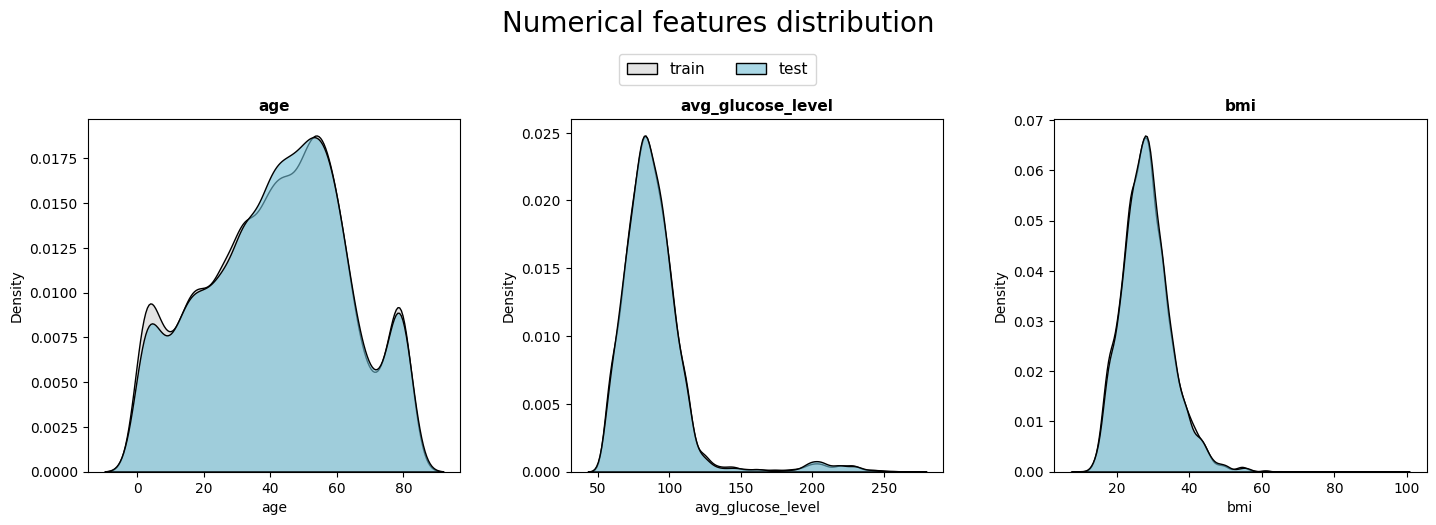

In [ ]:
# 수치형 변수 시각화
fig = plt.figure(figsize=(15, 5))
for idx, column in enumerate(num_columns):
    plt.subplot(1, 3, idx+1)
    plt.title(column, size=11, fontweight='bold')
    ax = sns.kdeplot(train[column], color='#d1d1d1', shade=True, label='train', alpha=0.6, edgecolor='black')
    sns.kdeplot(test[column], color='#72bfd6', shade=True, label='test', alpha=0.6, edgecolor='black')
fig.tight_layout(pad=3)
fig.legend(['train', 'test'], bbox_to_anchor=(0.57, 1.02), ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.05, 'Numerical features distribution', size=20, ha='center')
plt.show()

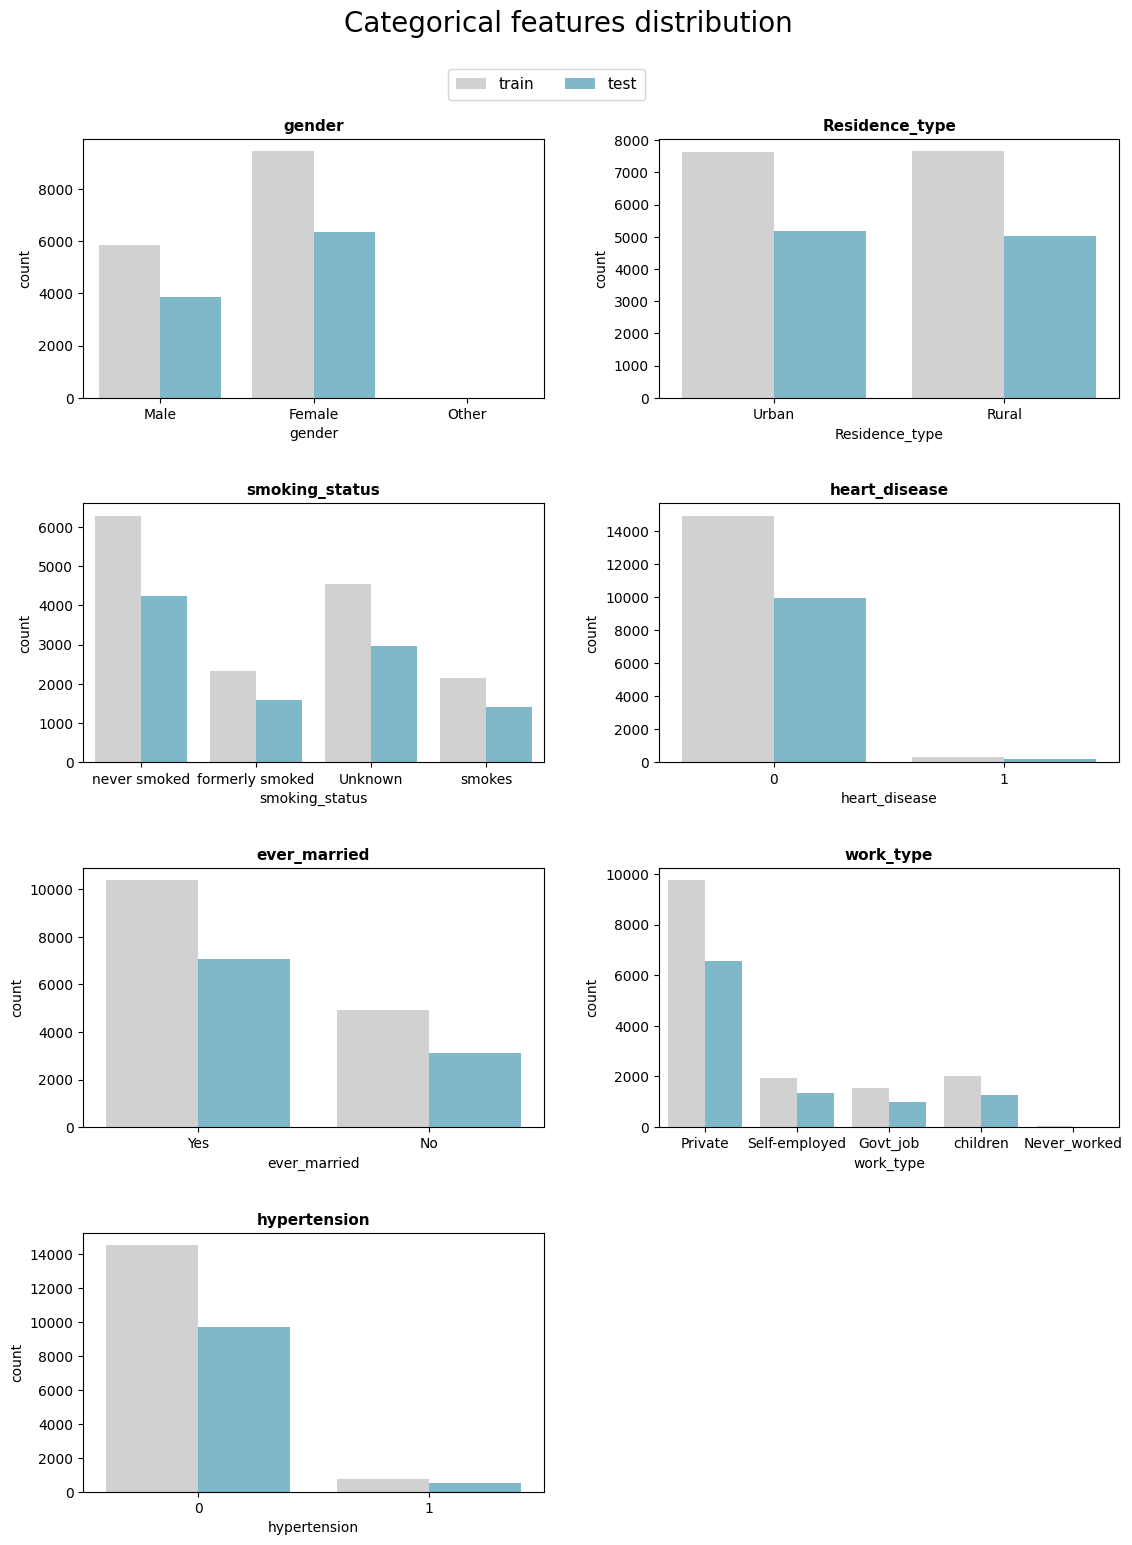

In [ ]:
# 범주형 변수 시각화
train['data'] = 'train'
test['data'] = 'test'
df = pd.concat([train, test])

fig = plt.figure(figsize=(12, 15))
for idx, column in enumerate(cat_columns):
    plt.subplot(4, 2, idx+1)
    plt.title(column, size=11, fontweight='bold')
    ax = sns.countplot(data=df, x=column, hue='data', palette=['#d1d1d1', '#72bfd6'])
    ax.get_legend().remove()
fig.tight_layout(pad=3)
fig.legend(['train', 'test'], bbox_to_anchor=(0.57, 1.01), ncol=2, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.03, 'Categorical features distribution', size=20, ha='center')
plt.show()

In [ ]:
train.drop('data', axis=1, inplace=True)
test.drop('data', axis=1, inplace=True)

### 3-2. Target distribution

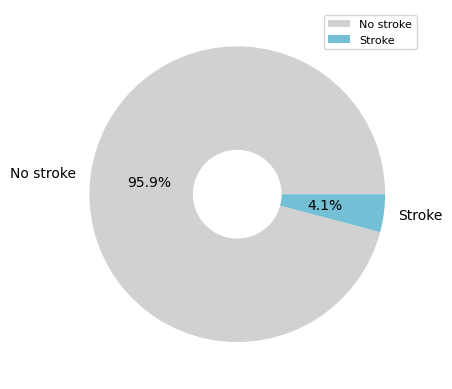

In [ ]:
info = train['stroke'].value_counts().reset_index()
info['index'] = info['index'].map({0: 'No stroke', 1: 'Stroke'})

pie = plt.pie(info['stroke'].tolist(), labels=info['index'].tolist(),
        wedgeprops=dict(width=0.7),
        colors=['#d1d1d1', '#72bfd6'], autopct='%.1f%%')
plt.legend(pie[0], info['index'].tolist(), fontsize=8)
plt.show()

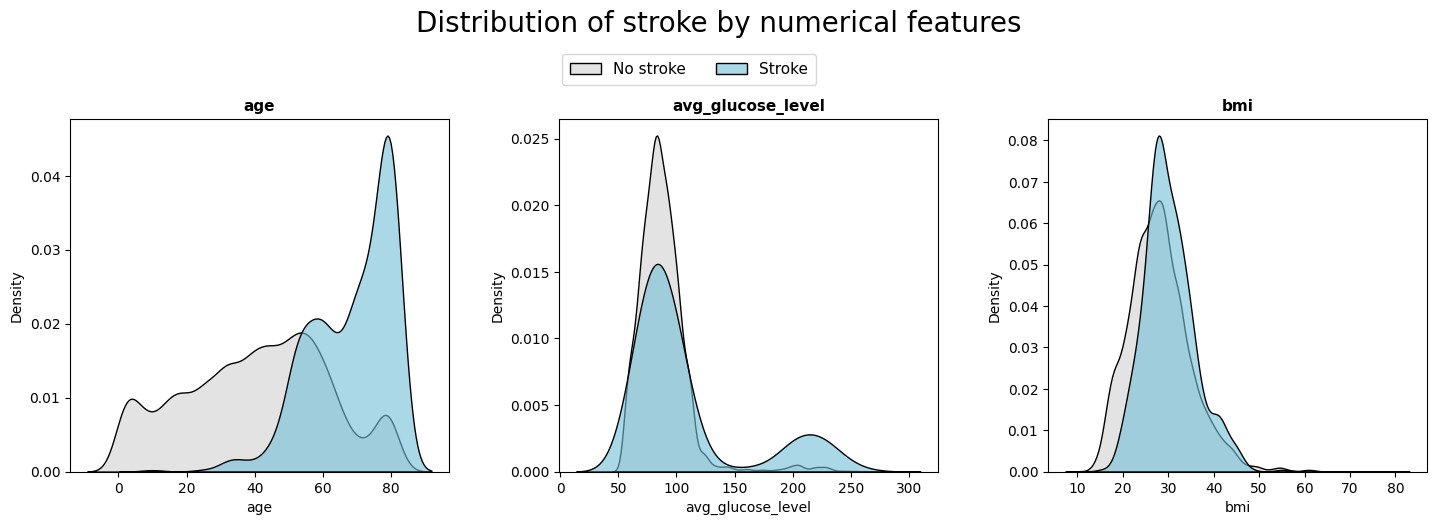

In [ ]:
# 수치형 변수 시각화
fig = plt.figure(figsize=(15, 5))
for idx, column in enumerate(num_columns):
    plt.subplot(1, 3, idx+1)
    plt.title(column, size=11, fontweight='bold')
    ax = sns.kdeplot(train[train['stroke']==0][column], color='#d1d1d1', shade=True, label='train', alpha=0.6, edgecolor='black')
    sns.kdeplot(train[train['stroke']==1][column], color='#72bfd6', shade=True, label='test', alpha=0.6, edgecolor='black')
fig.tight_layout(pad=3)
fig.legend(['No stroke', 'Stroke'], bbox_to_anchor=(0.57, 1.02), ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.05, 'Distribution of stroke by numerical features', size=20, ha='center')
plt.show()

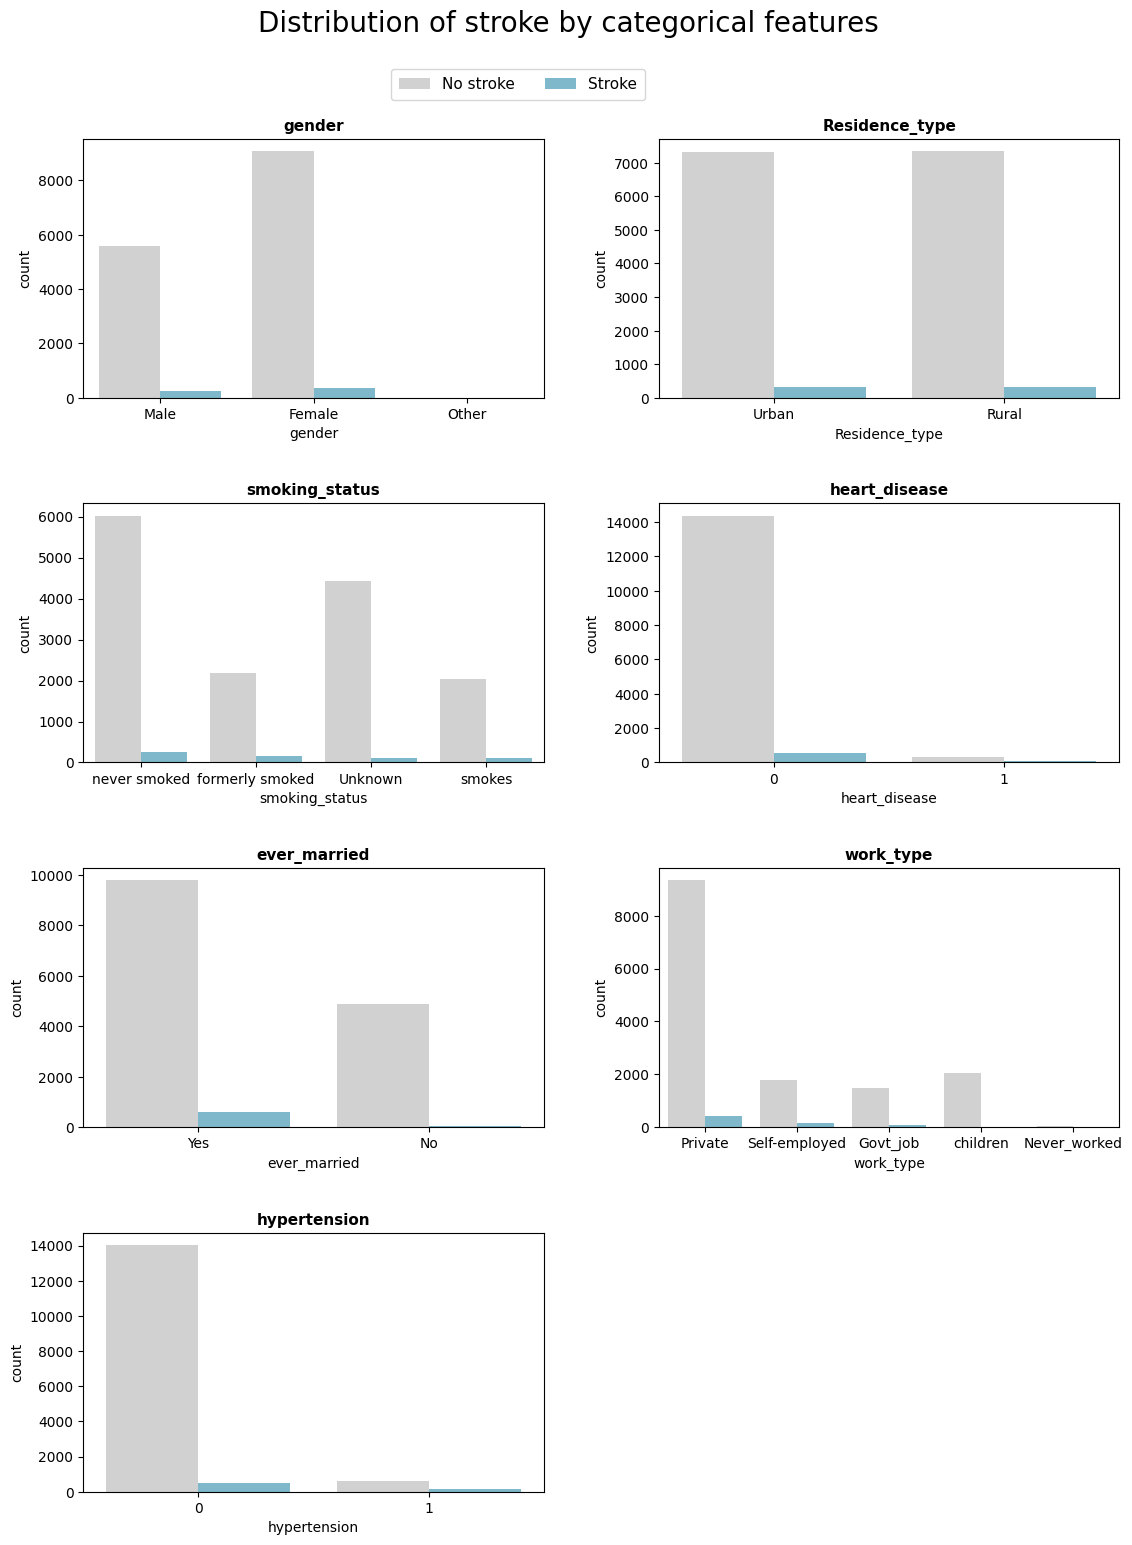

In [ ]:
# 범주형 변수 시각화
fig = plt.figure(figsize=(12, 15))
for idx, column in enumerate(cat_columns):
    plt.subplot(4, 2, idx+1)
    plt.title(column, size=11, fontweight='bold')
    ax = sns.countplot(data=train, x=column, hue='stroke', palette=['#d1d1d1', '#72bfd6'])
    ax.get_legend().remove()
fig.tight_layout(pad=3)
fig.legend(['No stroke', 'Stroke'], bbox_to_anchor=(0.57, 1.01), ncol=2, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.03, 'Distribution of stroke by categorical features', size=20, ha='center')
plt.show()

### 3-2. Correlation map

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
def show_corr_heatmap(df, title):
    tmp = df.copy()

    # 범주형 변수에 대해 라벨 인코딩 진행
    for col in cat_columns:
        le = LabelEncoder()
        tmp[col] = le.fit_transform(tmp[col])

    corr = tmp.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(15, 10))
    plt.title(title)
    sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', vmax=1, vmin=-1,
                square=True, mask = mask, cmap='RdYlBu_r')
    plt.show()

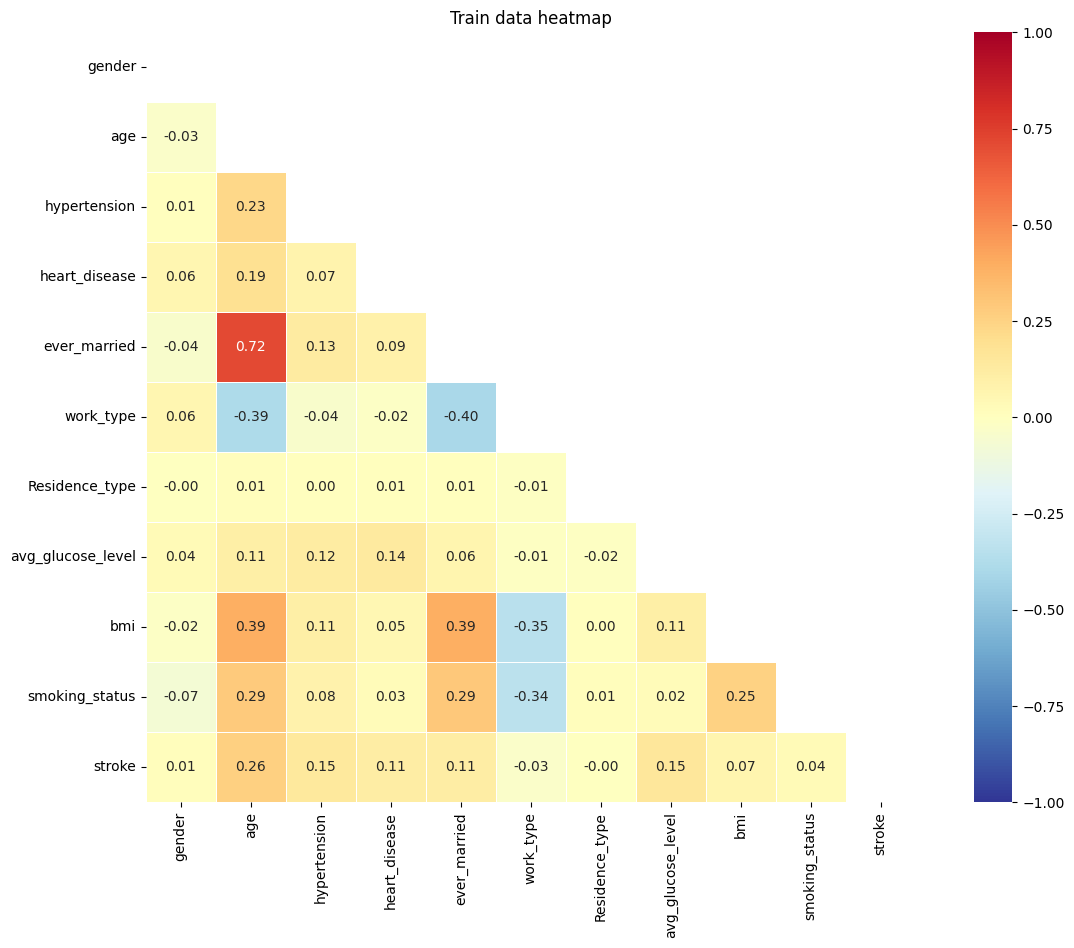

In [ ]:
show_corr_heatmap(train, 'Train data heatmap')

## 4. Preprocessing

In [ ]:
# CatBoost 모델을 위한 이상치 제거
train_cb = train.copy()

train.drop(train_cb[(train_cb['age']<31)&
                    (train_cb['stroke']==1)].index, inplace=True)

train.drop(train_cb[(train_cb['age']>70)&
                    (train_cb['avg_glucose_level']>200)&
                    (train_cb['hypertension']==1)&
                    (train_cb['heart_disease']==1)&
                    (train_cb['ever_married']=='Yes')&
                    (train_cb['stroke']==0)].index, inplace=True)

# 범주형 변수: 원-핫 인코딩
train_cb = pd.get_dummies(train_cb) # CatBoost 모델
train = pd.get_dummies(train) # NN 모델
test = pd.get_dummies(test)

In [ ]:
# CatBoost 모델: 이상치를 제거한 데이터 사용
X_cb = train_cb.drop('stroke', axis=1)
y_cb = train_cb['stroke']

# NN 모델: 이상치를 제거하지 않은 데이터 사용
X = train.drop('stroke', axis=1)
y = train['stroke']

## 5. Train Model
- 평가지표: `area under the ROC curve(AUC)`

### 5-1. Train CatBoost Model

In [ ]:
def get_norm_0to1(preds):
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

# Feature importance 그래프
def get_f_imp_plot(f_imp):
    f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
    f_imp.sort_values('avg_imp', ascending=False, inplace=True)

    fig = plt.figure(figsize=(15, 0.36*len(f_imp)))
    plt.title('Feature importances', size=20)
    ax = sns.barplot(data=f_imp, x='avg_imp', y='feature',
                     palette='Blues_d', linestyle='-',
                     linewidth=1, edgecolor='black')
    plt.ylabel('')
    plt.xlabel('')
    plt.show()

# 표준화한 predictions에 대한 분포
def get_preds_plot(preds):
    plt.figure(figsize=(15, 5))
    plt.title('Distribution of predictions', size=20)
    ax = sns.histplot(preds, bins=100)
    plt.ylabel('')
    plt.xlabel('')
    plt.show()

In [ ]:
cb_params = {'depth': 3,
             'learning_rate': 0.01,
             'rsm': 0.5,
             'subsample': 0.931,
             'l2_leaf_reg': 69,
             'min_data_in_leaf': 20,
             'random_strength': 0.175,
             'random_seed': 42,
             'use_best_model': True,
             'task_type': 'CPU',
             'bootstrap_type': 'Bernoulli',
             'grow_policy': 'SymmetricTree',
             'loss_function': 'Logloss',
             'eval_metric': 'AUC'}

f_imp = pd.DataFrame({'feature': X_cb.columns}) # Feature importance
predictions, scores = np.zeros(len(test)), []

FOLDS = 10
k = StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X_cb, y_cb)):
    cb_train = cb.Pool(data=X_cb.iloc[train_idx],
                       label=y_cb.iloc[train_idx])
    cb_valid = cb.Pool(data=X_cb.iloc[val_idx],
                       label=y_cb.iloc[val_idx])

    model = cb.train(params=cb_params,
                     dtrain=cb_train,
                     num_boost_round=10000,
                     evals=cb_valid,
                     early_stopping_rounds=500,
                     verbose=False)

    f_imp['fold_'+str(fold+1)] = model.get_feature_importance()
    val_preds = model.predict(cb_valid)
    val_score = roc_auc_score(y_cb.iloc[val_idx], val_preds)
    scores.append(val_score)

    predictions += model.predict(test) / FOLDS
    print(f'FOLD {fold+1} | AUC: {round(val_score, 4)}')

    del cb_train, cb_valid, val_preds, val_score, model
    gc.collect()

print('='*45)
print(f'Mean AUC: {round(np.mean(scores), 4)}')

predictions = get_norm_0to1(predictions)
cb_preds = predictions.copy()

FOLD 1 | AUC: 0.8951
FOLD 2 | AUC: 0.8779
FOLD 3 | AUC: 0.8874
FOLD 4 | AUC: 0.8961
FOLD 5 | AUC: 0.8992
FOLD 6 | AUC: 0.8897
FOLD 7 | AUC: 0.8839
FOLD 8 | AUC: 0.8891
FOLD 9 | AUC: 0.8965
FOLD 10 | AUC: 0.8888
Mean AUC: 0.8904


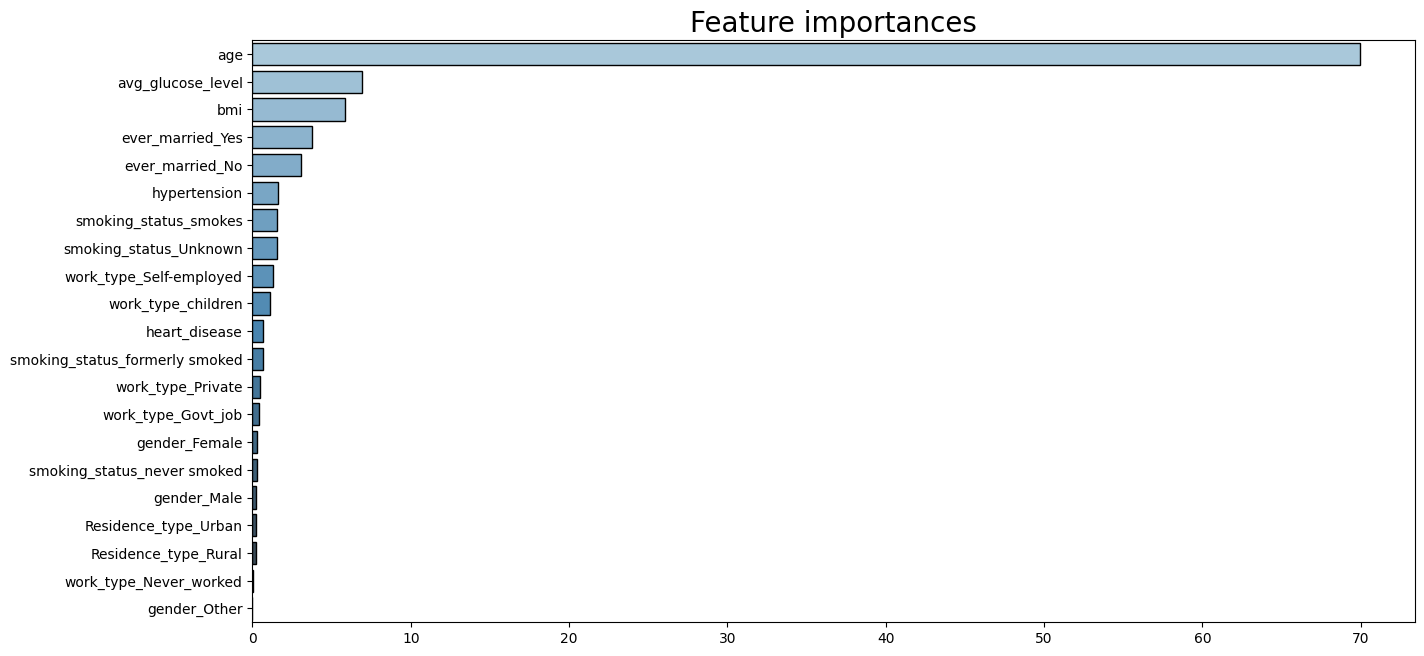

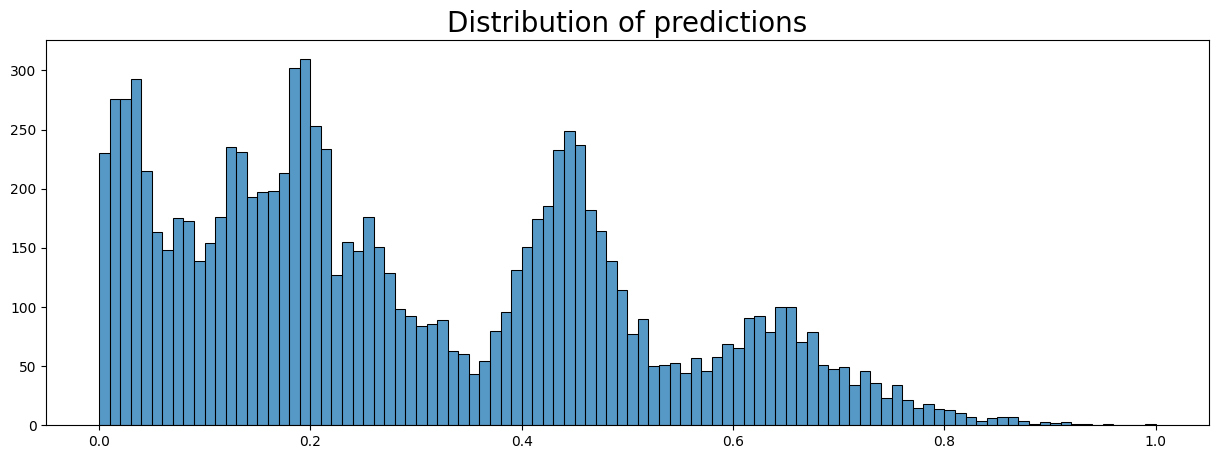

In [ ]:
get_f_imp_plot(f_imp)
get_preds_plot(predictions)

### 5-2. Train NN Model

In [ ]:
# 수치형 변수에 대해 표준화 진행
scaler = StandardScaler()
X[num_columns] = scaler.fit_transform(X[num_columns])
test[num_columns] = scaler.transform(test[num_columns])

X = X.values
y = y.values
test = test.values

In [ ]:
def my_model():
    x_input = Input(shape=(X.shape[-1]), name='input')
    x1 = Dense(256, activation='relu')(x_input)
    d1 = Dropout(0.1)(x1)
    x2 = Dense(128, activation='relu')(d1)
    d2 = Dropout(0.1)(x2)
    x3 = Dense(64, activation='relu')(d2)
    d3 = Dropout(0.1)(x3)
    output =  Dense(1, activation='sigmoid', name='output')(d3)

    model = Model(x_input, output, name='nn_model')

    return model

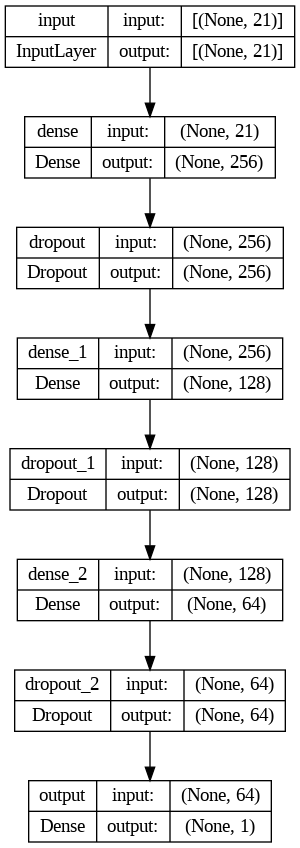

In [ ]:
model = my_model()
plot_model(model, to_file='nn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
VERBOSE = False
BATCH_SIZE = 32
predictions, scores = [], []

lr = ReduceLROnPlateau(monitor='val_auc', factor=0.7,
                       patience=5, verbose=VERBOSE)

es = EarlyStopping(monitor='val_auc', patience=15,
                   verbose=VERBOSE, mode='max',
                   restore_best_weights=True)

FOLDS = 10
k = StratifiedKFold(n_splits=FOLDS, random_state=42, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = my_model()
    model.compile(optimizer='adam',
                  loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.1, gamma=3),
                  metrics='AUC')

    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=300,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE,
              class_weight={0: 1, 1: 10},
              callbacks=[lr, es])

    y_pred = get_norm_0to1(model.predict(X_val))
    val_score = roc_auc_score(y_val, y_pred)
    scores.append(val_score)

    predictions.append(model.predict(test))
    print(f'FOLD {fold+1} | AUC: {round(val_score, 4)}')

print('='*45)
print(f'Mean AUC: {round(np.mean(scores), 4)}')

predictions = get_norm_0to1(np.squeeze(np.mean(predictions, axis=0)))
nn_preds = predictions.copy()

319/319 [==============================] - 0s 1ms/step
FOLD 1 | AUC: 0.9036
319/319 [==============================] - 1s 2ms/step
FOLD 2 | AUC: 0.8829
319/319 [==============================] - 0s 1ms/step
FOLD 3 | AUC: 0.8571
319/319 [==============================] - 0s 1ms/step
FOLD 4 | AUC: 0.8928
319/319 [==============================] - 0s 1ms/step
FOLD 5 | AUC: 0.931
319/319 [==============================] - 1s 2ms/step
FOLD 6 | AUC: 0.8839
319/319 [==============================] - 1s 2ms/step
FOLD 7 | AUC: 0.8765
319/319 [==============================] - 1s 2ms/step
FOLD 8 | AUC: 0.8839
319/319 [==============================] - 0s 1ms/step
FOLD 9 | AUC: 0.8886
319/319 [==============================] - 0s 1ms/step
FOLD 10 | AUC: 0.8542
Mean AUC: 0.8854


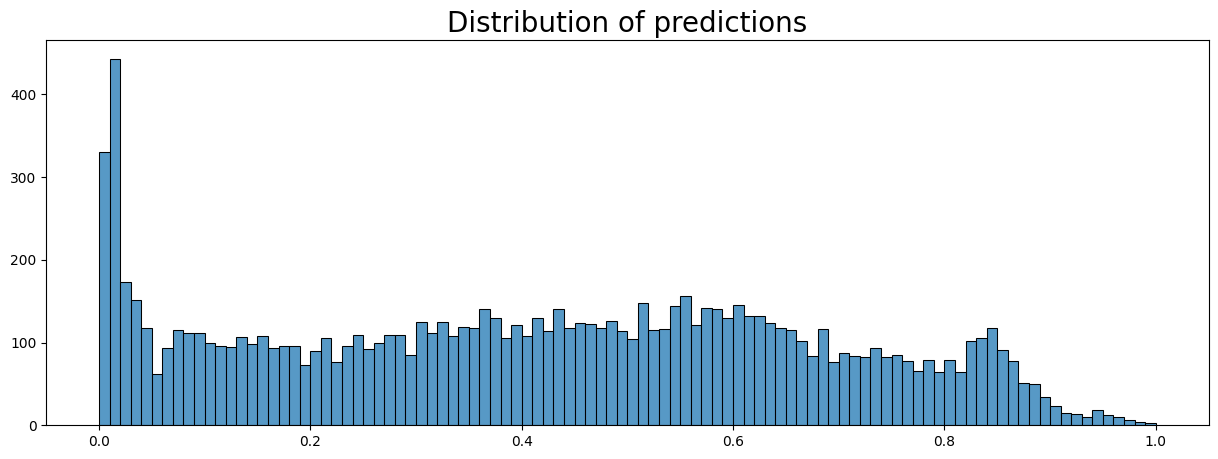

In [ ]:
get_preds_plot(predictions)

## 6. Submission

In [ ]:
submission = pd.read_csv("sample_submission.csv")

submission['stroke'] = cb_preds*0.7 + nn_preds*0.3
submission.to_csv('submission.csv', index=False)

submission.head()

,id,stroke
0,15304,0.492395
1,15305,0.725686
2,15306,0.022252
3,15307,0.579375
4,15308,0.290672


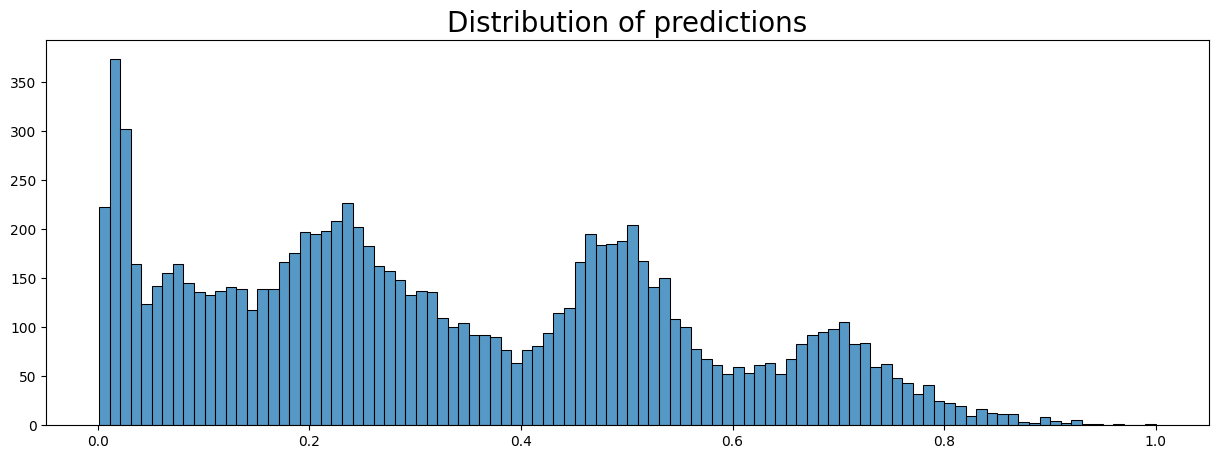

In [ ]:
get_preds_plot(submission['stroke'])